## Runnning Upper bound using 25% prune rate to compare with 50%

I ran this because their performances were very similar under the prune rate analysis, so i wanted to confirm that 50% had the best performance on average.

In [2]:
import torch
import numpy as np
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from Results import Results

results = Results(base_dir="results")

# ---------------------------------------------------------
# Fully Supervised: 25% pruned model with 100% labels
# ---------------------------------------------------------
PRETRAIN_EPOCHS = 200
FINETUNE_EPOCHS = 100
LR = 0.001
MOMENTUM = 0.9
PRUNE_RATE = 0.25
SEEDS = [1, 42, 123, 456, 12345]
CONFIG_TAG = "fully_supervised_100pct"

def run_fully_supervised(seed):
    """Train 25% pruned model with 100% of labels."""
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=1.0, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    print(f"   Training samples: {len(data_dict['labeled_train'])}")

    # --- Phase 1: Pre-train 2x wide network ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=f"{CONFIG_TAG}_pretrain",
        lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(hidden_size=2056, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    pre_prune_test, pretrain_converged = train_loop(
        model, loaders, device, results=results, epochs=PRETRAIN_EPOCHS
    )

    # --- Phase 2: Prune 25% ---
    model.prune(PRUNE_RATE)
    _, post_prune_test = model.evaluate(loaders["test"], device)
    print(f"      Post-prune ({PRUNE_RATE:.0%}): {post_prune_test:.4f} | Sparsity: {model.sparsity():.1%}")

    # --- Phase 3: Fine-tune ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=CONFIG_TAG, lr=LR, momentum=MOMENTUM
    )

    final_test, finetune_converged = train_loop(
        model, loaders, device, results=results, epochs=FINETUNE_EPOCHS, print_every=10
    )

    print(f"   -> Pre: {pre_prune_test:.4f} | Post: {post_prune_test:.4f} | Final: {final_test:.4f}")
    return final_test

# ---------------------------------------------------------
# Run
# ---------------------------------------------------------
print("=" * 70)
print("FULLY SUPERVISED BASELINE (100% Labels, 25% Pruned)")
print("=" * 70)

fully_supervised_results = []
for seed in SEEDS:
    print(f"\n   Seed {seed}...")
    acc = run_fully_supervised(seed)
    fully_supervised_results.append(acc)

fs_accs = np.array(fully_supervised_results)

FULLY_SUPERVISED_ACC = fs_accs.mean()
FULLY_SUPERVISED_STD = fs_accs.std()
print(f"\n>>> Upper bound: {FULLY_SUPERVISED_ACC:.4f} +/- {FULLY_SUPERVISED_STD:.4f}")

FULLY SUPERVISED BASELINE (100% Labels, 25% Pruned)

   Seed 1...
      Epoch 020 | Train Acc: 0.9313 | Val Acc: 0.8907
      >>> Overfitting at epoch 22
   Pruned 1464900/5859600 weights (25.0%) at threshold=0.000008
      Post-prune (25%): 0.8910 | Sparsity: 25.0%
   Training samples: 112000
      Epoch 020 | Train Acc: 0.9318 | Val Acc: 0.8931
      >>> Overfitting at epoch 23
   Pruned 1464900/5859600 weights (25.0%) at threshold=0.000007
      Post-prune (25%): 0.8907 | Sparsity: 25.0%
      >>> Overfitting at epoch 32
   -> Pre: 0.8907 | Post: 0.8907 | Final: 0.8920

   Seed 12345...
   Training samples: 112000
      >>> Overfitting at epoch 15
   Pruned 1464900/5859600 weights (25.0%) at threshold=0.000013
      Post-prune (25%): 0.8891 | Sparsity: 25.0%
      >>> Overfitting at epoch 19
   -> Pre: 0.8886 | Post: 0.8891 | Final: 0.8926

>>> Upper bound: 0.8935 +/- 0.0012


Longest run: 28 epochs — shorter seeds end where they converged.


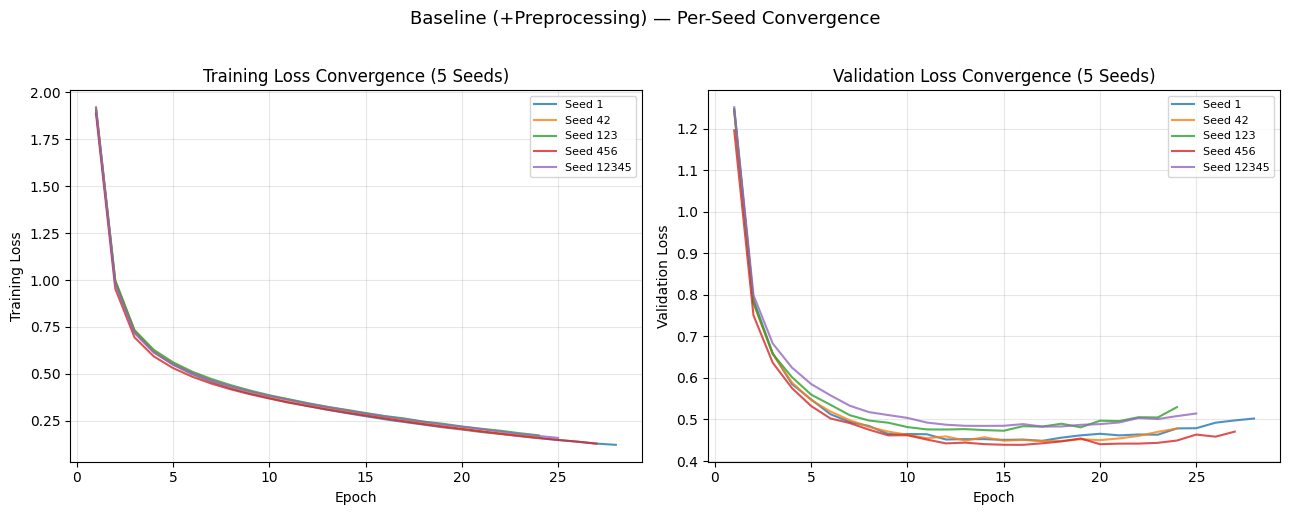

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load all 5 seeds for the +preprocessing baseline
seeds = [1, 42, 123, 456, 12345]
base = "results/+preprocessing"

dfs = {}
for s in seeds:
    path = os.path.join(base, str(s), "results_lr0.01_momentum0.5.csv")
    dfs[s] = pd.read_csv(path)

max_epochs = max(len(df) for df in dfs.values())
print(f"Longest run: {max_epochs} epochs — shorter seeds end where they converged.")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
colors = plt.cm.tab10.colors

# --- Left: Training Loss ---
for i, s in enumerate(seeds):
    df = dfs[s]
    ax1.plot(df["epoch"], df["train_loss"], label=f"Seed {s}", color=colors[i], alpha=0.8)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss Convergence (5 Seeds)")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Right: Validation Loss ---
for i, s in enumerate(seeds):
    df = dfs[s]
    ax2.plot(df["epoch"], df["val_loss"], label=f"Seed {s}", color=colors[i], alpha=0.8)

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss Convergence (5 Seeds)")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.suptitle("Baseline (+Preprocessing) — Per-Seed Convergence", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("convergence_baseline.png", dpi=150, bbox_inches="tight")
plt.show()